In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

import pandas as pd
import os

# List files in the downloaded directory
files = os.listdir(path)
print(f"Files in the directory: {files}")

# Check if 'IMDB Dataset.csv' is present and adjust file path if needed
# Example: If the CSV is directly in the 'path' directory:
if 'IMDB Dataset.csv' in files:
  data_path = os.path.join(path, 'IMDB Dataset.csv')
# Example: If the CSV is in a subfolder, like 'data':
elif os.path.exists(os.path.join(path, 'data', 'IMDB Dataset.csv')):
  data_path = os.path.join(path, 'data', 'IMDB Dataset.csv')
else:
  raise FileNotFoundError(f"Could not find 'IMDB Dataset.csv' in {path} or its subfolders")

df = pd.read_csv(data_path)

# rename column
df.rename(columns={'label (depression result)': 'Sentiment'}, inplace=True)
df.rename(columns={'message to examine': 'review'}, inplace=True)

# Instead of dropping 'Index', try setting 'index_col' to False during reading:
# df = pd.read_csv(data_path, index_col=False)
#OR reset the index:
df = df.reset_index(drop=True) # Reset the index and drop the old index

Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1
Files in the directory: ['IMDB Dataset.csv']


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
!pip install nltk
import nltk, re
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [7]:

from nltk.tokenize.toktok import ToktokTokenizer # Import ToktokTokenizer
tokenizer = ToktokTokenizer()
#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

In [8]:
from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

<ipython-input-8-c2fa9c236389>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [9]:
import re
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

In [10]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

In [11]:
from nltk.corpus import stopwords # Import the stopwords module

stop=set(stopwords.words('english')) # Now stopwords is correctly referenced
print(stop)

# ... (rest of your code) ...

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

{'yourself', "don't", 'had', 'yours', 'most', 'who', 'did', 'whom', 'which', 'mustn', 'myself', "it's", "you've", 'by', 'doing', 'haven', 'my', 'on', 'of', 'now', 's', 'after', "didn't", 'ma', 'she', 'wasn', 'an', 'through', 'a', 'down', 'above', "isn't", 'his', 'here', 'they', 'needn', 'your', 'for', 'than', 'o', 'hers', "shouldn't", 'itself', 'ourselves', 'doesn', 'herself', 'out', 'that', "haven't", 'until', 'wouldn', 'between', 'such', 'but', 'was', "you'll", 'very', 'hadn', 'some', 'isn', 'when', 'and', 'her', 'our', 'because', 'into', 'once', 'do', 'didn', 'more', 'them', 'to', 'y', 'both', "you'd", 'or', 'couldn', 'against', 'up', 'is', 'don', "wouldn't", 'i', 'should', 'this', 'ain', 'before', "she's", 'while', 'be', 'mightn', 'these', 'about', "shan't", "you're", 'does', 'theirs', 'having', 'have', 'will', 'nor', 'over', 'shan', 'in', 'so', 'how', 'if', 'from', "weren't", 'we', 'where', "mustn't", 'll', 'with', 'few', "wasn't", "won't", 'am', 'at', 'yourselves', 'me', 'as', 'w

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Columns in your dataset: 'review' and 'sentiment'
X = df['review']
y = df['sentiment']

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')])
    return text

# Apply cleaning function to the reviews
X_cleaned = X.apply(clean_text)


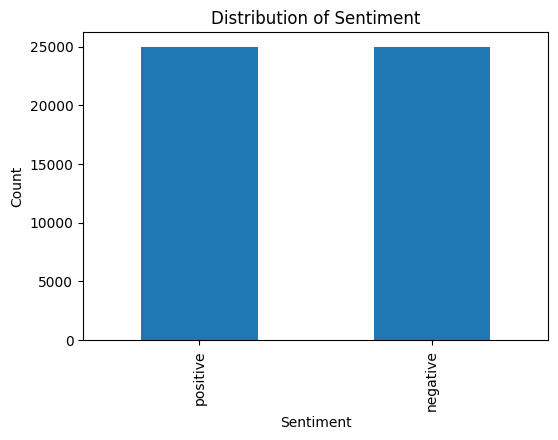

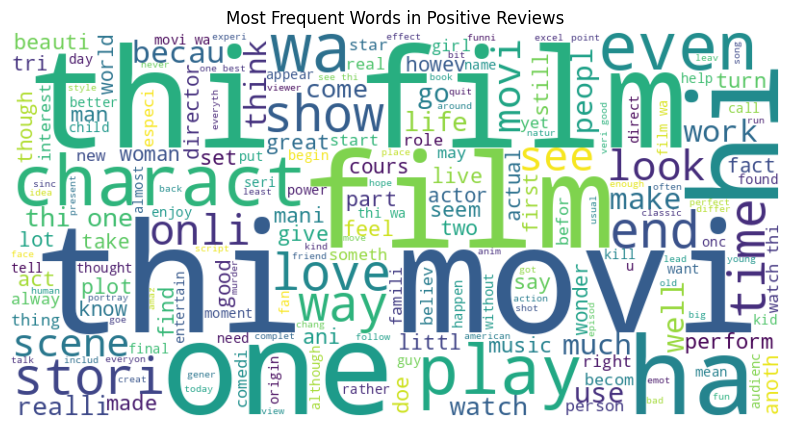

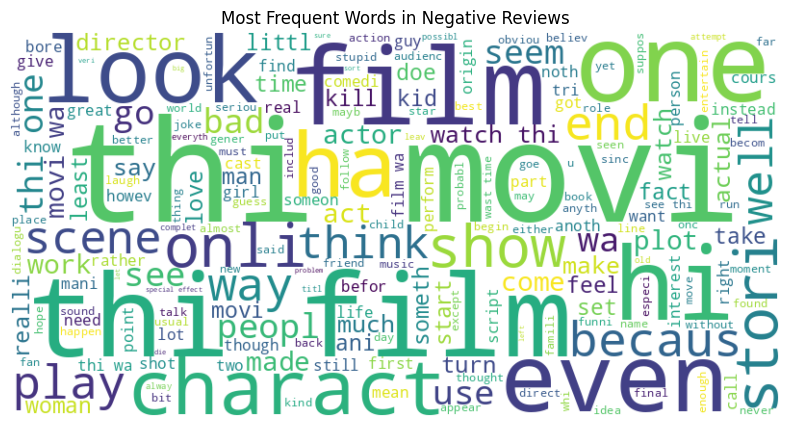

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Distribution of Sentiment
sentiment_counts = y.value_counts()
plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Most Frequent Words (Word Cloud)
positive_reviews = ' '.join([text for text in X_cleaned[y == 'positive']])
negative_reviews = ' '.join([text for text in X_cleaned[y == 'negative']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews')
plt.show()


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)


In [17]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)  # Using unigrams and bigrams
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [18]:
# Logistic Regression Model
lr = LogisticRegression()

# Hyperparameter tuning using Grid Search
param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Parameters: ", grid.best_params_)

# Train the model with the best parameters
best_lr = grid.best_estimator_
best_lr.fit(X_train_tfidf, y_train)


Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


LogisticRegression(C=1, solver='liblinear')

In [19]:
# Predict on the test set
y_pred = best_lr.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print(classification_report(y_test, y_pred))


Accuracy: 0.89
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [20]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
import joblib
path='/content/drive/MyDrive/NLP/'
# Save the model
joblib.dump(best_lr, f'{path}logistic_regression_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, f'{path}tfidf_vectorizer.pkl')

# To load the model and vectorizer later
# loaded_model = joblib.load(f'{path}logistic_regression_model.pkl')
# loaded_tfidf = joblib.load(f'{path}tfidf_vectorizer.pkl')


['/content/drive/MyDrive/NLP/tfidf_vectorizer.pkl']